# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 8. Partial Pooling - Varying Intercept

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data
import pooled_model
import unpooled_model

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ac21a09143e1678f06ad0a8c64d4c81 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56b08b63d48247e5e31d7c6f26b156c8 NOW.


## Partial pooling: varying intercept

We can extend partial pooling to a linear model of the relationship between measured log(radon), the prevailing county radon level, and the floor at which the measurement was made. In the linear model, the measured radon level in a household $y_i$ is a function of the floor at which measurement took place, $x_i$, with parameters $\alpha_{j[i]}$ (the prevailing radon level in the county) and $\beta$ (the influence of the floor), and residual error $\epsilon_i$.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

In this linear model, the prevailing radon level $\alpha_{j[i]}$ is the intercept, with random Normal effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

The residual error is also sampled from a Normal distribution:

$$\epsilon_i \sim N(0, \sigma_y^2)$$

This approach is similar to a least squares regression, but the multilevel modelling approach allows parameter distributions - *information* to be *shared* across groups, which can lead to more reasonable estimates of parameters with relatively little data. In this example, using a common distribution for prevailing county-level radon spreads the information about likely radon levels such that our estimates for counties with few observations should be less extreme.

### Specifying the model

We define the model in `stan`, as usual specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$. $\sigma_y$ is sampled from a Uniform distribution.

$$y \sim N(\hat{y}, \sigma_y^2)$$
$$\sigma_{y} \sim U(0, 100)$$

The transformed variable $\hat{y}$ is a linear function of $x_i$, the floor at which radon is measured. The parameters are the value of $\alpha$ associated with the county $i$ ($i=1,\ldots,N$) in which each household is found, and the effect due to which floor is used for measurement.

$$\hat{y_i} = {\alpha_{j[i]} + \beta x_i}$$

The value of $\alpha$ for each county $j[i]$, is Normally distributed with mean $\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$. $\sigma_{\alpha}$ is sampled from a Uniform distribution, between 0 and 100. $\mu_{\alpha}$ is an unconstrained real value. There is a common mean and variance underlying each of the prevailing radon levels in each county.

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$

The value of $\beta$ is assumed to be Normally distributed about zero, with unit variance:

$$\beta \sim N(0, 1)$$


In `data`:
* `J` is the number of counties (`int`)
* `N` is the number of samples (`int`)
* `county` is a list of `N` values from 1-85, specifying the county index each measurement
* `x` is a `vector` of indices for which floor the radon measurements were taken at each household
* `y` is a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`vector`, one value per county), representing $\alpha$, the vector of prevailing radon levels for each county.
* `b` (`real`) representing $\beta$, the effect of floor choice
* `mu_a`, a `real` corresponding to $\mu_{\alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* `sigma_a` is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [2]:
varying_intercept = """
data {
  int<lower=0> J;
  int<lower=0> N;
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
}
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[county[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal(mu_a, sigma_a);
  
  b ~ normal(0,1);
  
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

### Fitting the model

As usual, we map Python variables to those in the model, and run the fit:

In [3]:
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

varying_intercept_data = {'N': len(clean_data.log_radon),
                          'J': len(n_county),
                          'county': clean_data.county + 1,
                          'x': clean_data.floor_measure,
                          'y': clean_data.log_radon}

varying_intercept_fit = pystan.stan(model_code=varying_intercept,
                                    data=varying_intercept_data,
                                    iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02868d8446abea90f6f542cf9fa9dd95 NOW.


We can then collect the county-level estimates of prevailing radon, the *intercept* of the model, $\alpha_{j[i]}$, from `a` (1000 iterations x 85 counties):

In [4]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])

## Interpreting the model output

We can visualise the distribution of these estimates, by county, with a boxplot:

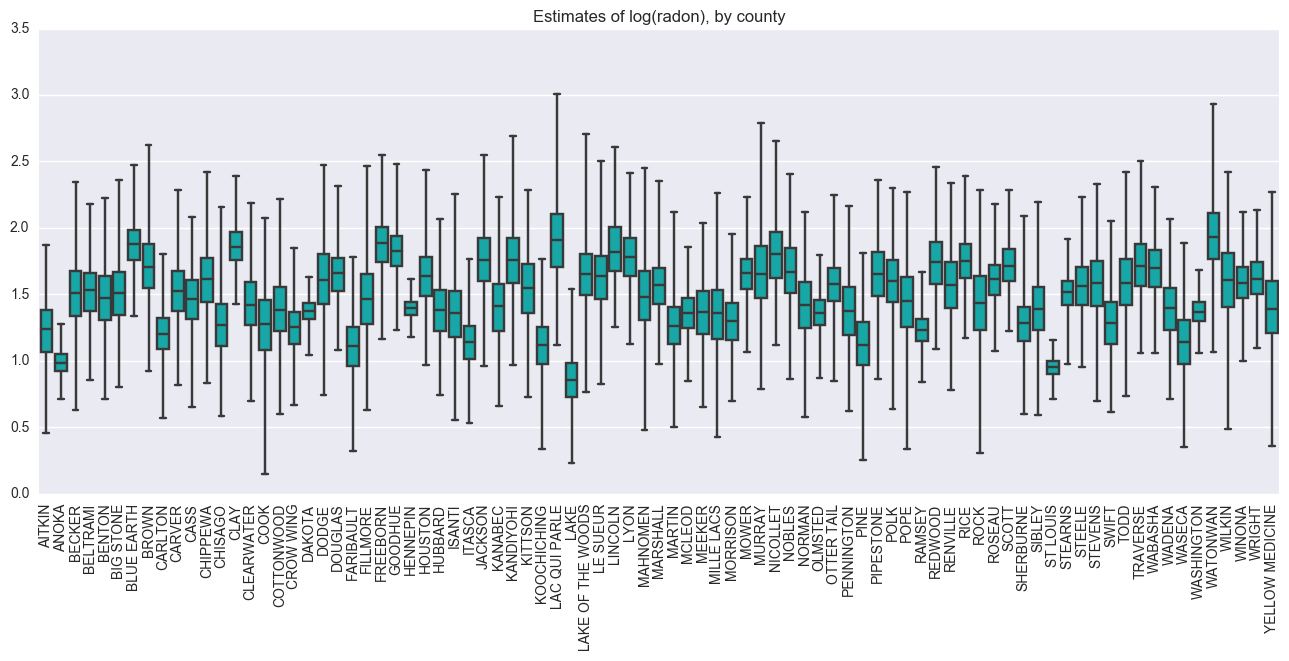

In [5]:
# Boxplot of estimated log(radon) by county
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=a_sample, whis=np.inf, color="c")
g.set_xticklabels(clean_data.mn_counties, rotation=90)  # label counties
g.set_title("Estimates of log(radon), by county")
g;

There's quite some variation in prevailing radon level by county, and we can see that the counties with the largest number of samples (e.g. St Louis) have the tightest range of estimated values. Also, the counties with the fewest households (e.g. Lac Qui Parle) have the widest range of estimates.

We can visualise the distribution of parameter estimates for $\beta$ and $\sigma_{alpha}$:

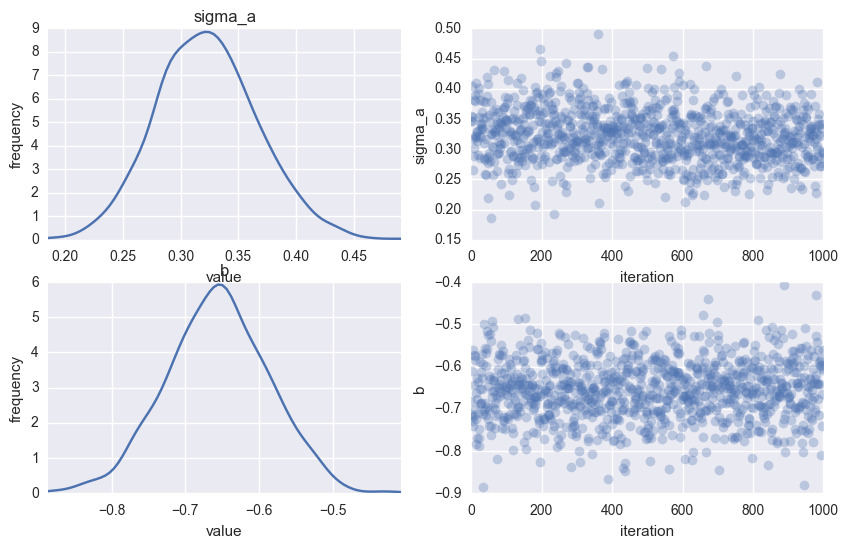

In [6]:
# 2x2 plot of parameter estimate data
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# density plot of sigma_a estimate
sns.kdeplot(varying_intercept_fit['sigma_a'], ax=axes[0][0])
axes[0][0].set_xlim(varying_intercept_fit['sigma_a'].min(), varying_intercept_fit['sigma_a'].max())

# scatterplot of sigma_a estimate
axes[0][1].plot(varying_intercept_fit['sigma_a'], 'o', alpha=0.3)

# density plot of beta estimate
sns.kdeplot(varying_intercept_fit['b'], ax=axes[1][0])
axes[1][0].set_xlim(varying_intercept_fit['b'].min(), varying_intercept_fit['b'].max())

# scatterplot of beta estimate
axes[1][1].plot(varying_intercept_fit['b'], 'o', alpha=0.3)

# add titles/labels
axes[0][0].set_title("sigma_a")
axes[1][0].set_title("b")
axes[0][0].set_ylabel("frequency")
axes[1][0].set_ylabel("frequency")
axes[0][0].set_xlabel("value")
axes[1][0].set_xlabel("value");
axes[0][1].set_ylabel("sigma_a")
axes[1][1].set_ylabel("b")
axes[0][1].set_xlabel("iteration")
axes[1][1].set_xlabel("iteration");

The estimate for $\beta$, the effect of measuring at the ground floor rather than the basement, has a centre at approximately -0.66. We can interpret this to imply that measurements at the ground floor are about half ($\exp(-0.66) \approx 0.5)$ the radon level of the basement, once the prevailing radon level of the county is accounted for.

We can plot the linear relationships by county, to see how the fitted model estimates vary:

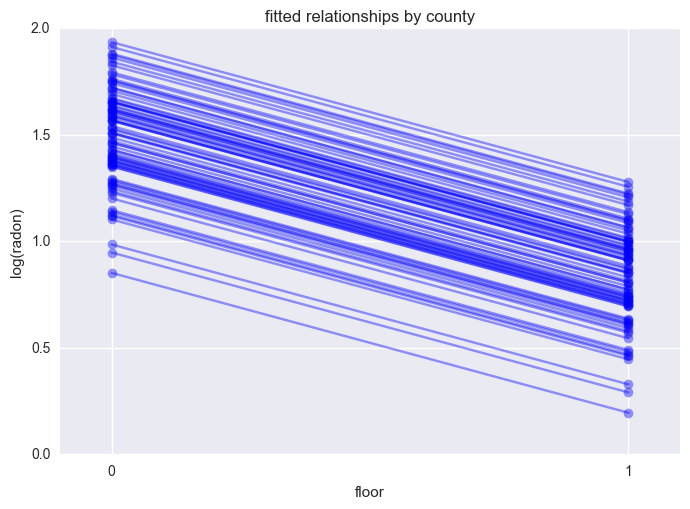

In [7]:
xvals = np.arange(2)  # floor
bp = varying_intercept_fit['a'].mean(axis=0)  # mean a (intercept) by county
mp = varying_intercept_fit['b'].mean()        # mean b (slope/floor effect) across state
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xticks([0, 1])
plt.xlim(-0.1, 1.1)
plt.ylim(0, 2)
plt.title("fitted relationships by county")
plt.xlabel("floor")
plt.ylabel("log(radon)");

It is clear from this plot that we have fitted the same floor effect to each county, but with a different prevailing radon level in each county. There are three counties with lower fitted radon estimates, but the bulk of counties form a set of similar fits.

We can see whether partial pooling of prevailing county-level radon estimate has provided objectively more reasonable estimates than pooled or unpooled models, for counties with small sample sizes:

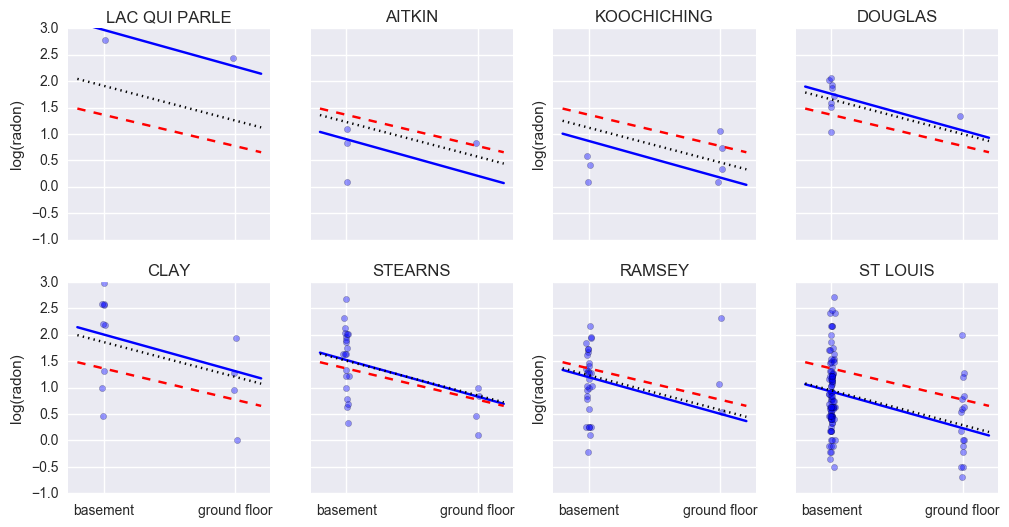

In [8]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                   'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(sample_counties):
    # raw data
    y = clean_data.srrs_mn.log_radon[clean_data.srrs_mn.county == c]
    x = clean_data.srrs_mn.floor[clean_data.srrs_mn.county == c]

    # unpooled fit
    m = unpooled_model.unpooled_estimates[c]
    b = unpooled_model.unpooled_fit['beta'].mean()
    
    # plot data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)        # raw data
    axes[i].plot(xvals, b * xvals + m, 'b-')                                 # unpooled fit
    axes[i].plot(xvals, pooled_model.m0 * xvals + pooled_model.b0, 'r--')    # pooled fit
    axes[i].plot(xvals, mp * xvals + bp[clean_data.county_lookup[c]], 'k:')  # partial pooling fit
    
    # plot labels
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['basement', 'ground floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel('log(radon)')

Comparisons against the pooled model (red dashed line) show that, in most cases, the unpooled or partially-pooled fit produces a different, and improved, estimate at the county level.

Comparisons between the unpooled (blue solid line) and partially-pooled (black dotted line) show that for counties with many datapoints the fits are very similar, but where the counties have few datapoints, the partially-pooled fits are not as extreme.